In [146]:
import numpy as np
import matplotlib.pyplot as plt

from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca
from modelbase.ode import ratefunctions as rf

In [147]:
G=Model()
G.add_compounds(["C","Chl","N"])
p={
"Pcref":3,
"Vcmax":0.6,
"αchl":0.46,
"Rc":0,
"Rn":0,
"Rchl":0,
"Knit":1,
"θNmax":0.3,
"Qmin":0.04,
"Qmax":0.20,
"cost":2.0,
"I":159,
"DIN": 250,
"n": 1
}
G.add_parameters(p)
G.parameters

{'Pcref': 3,
 'Vcmax': 0.6,
 'αchl': 0.46,
 'Rc': 0,
 'Rn': 0,
 'Rchl': 0,
 'Knit': 1,
 'θNmax': 0.3,
 'Qmin': 0.04,
 'Qmax': 0.2,
 'cost': 2.0,
 'I': 159,
 'DIN': 250,
 'n': 1}

In [148]:
def Q (N, C):
    return (N/C)
def θC (Chl, C):
    return (Chl/C)
def θN (Chl, N):
    return (Chl/N)
def Rc (Rc):
    return Rc
def Rchl (Rchl):
    return Rchl
def Rn (Rn):
    return Rn
def Pcmax (Pcref, Q, Qmin, Qmax):
    return Pcref * ((Q-Qmin)/(Qmax-Qmin))
def Ik (Pcmax,αchl, θC):
    return Pcmax/( αchl * θC)
def Pchl(θNmax,Pc,αchl,θC,I):
    return (θNmax*Pc)/ (αchl*θC*I)
def Vcref (Pcref,Qmax):
    return Pcref*Qmax
def Vcn (Vcref, Qmax, Q, Qmin, DIN, Knit, n):
    return Vcref*((Qmax-Q)/(Qmax-Qmin))**n *(DIN/(DIN+Knit))
def chlorophyll_syn_regulation (Pchl,Vcn,θC):
    return (Pchl*Vcn)/θC
def nitrogen_uptake (Vcn, Q):
    return (Vcn/Q)
def Pc(Pcmax, I, Ik):
    return Pcmax * (1 - np.exp(-(I/Ik)))
def cost_Vcn(cost, Vcref, Qmax, Q, Qmin, DIN, Knit, n):
    return cost * Vcref * (((Qmax-Q)/(Qmax-Qmin))**n) * (DIN/(DIN+Knit))
def growth_rate (Pc, cost_Vcn, Rc):
    return (Pc - cost_Vcn - Rc)


In [149]:
G.add_algebraic_module_from_args(
    module_name= "Q",
    function= Q,
    derived_compounds= ["Q"],
    args=["N","C"]
)
G.add_algebraic_module_from_args(
    module_name="θC",
    function=  θC,
    derived_compounds=["θC"],
    args=["Chl","C"]
)
G.add_algebraic_module_from_args(
    module_name="θN",
    function=  θN,
    derived_compounds=["θN"],
    args=["Chl","N"]
)
G.add_algebraic_module_from_args(
    module_name="Rc",
    function= Rc,
    derived_compounds=["Rc"],
    args=["Rc"]
)
G.add_algebraic_module_from_args(
    module_name="Rchl",
    function= Rchl,
    derived_compounds=["Rchl"],
    args=["Rchl"]
)
G.add_algebraic_module_from_args(
    module_name="Rn",
    function= Rn,
    derived_compounds=["Rn"],
    args=["Rn"]
)

G.add_algebraic_module_from_args(
    module_name="Pcmax",
    function= Pcmax,
    derived_compounds=["Pcmax"],
    args=["Pcref", "Q", "Qmin", "Qmax"]
)
G.add_algebraic_module_from_args(
    module_name="Ik",
    function= Ik,
    derived_compounds=["Ik"],
    args=["Pcmax","αchl", "θC"]
)
G.add_algebraic_module_from_args(
    module_name="Pc",
    function= Pc,
    derived_compounds=["Pc"],
    args=["Pcmax","I","Ik"],
)
G.add_algebraic_module_from_args(
    module_name="Pchl",
    function= Pchl,
    derived_compounds=["Pchl"],
    args=["θNmax","Pc","αchl","θC","I"]
)
G.add_algebraic_module_from_args(
    module_name="Vcref",
    function= Vcref,
    derived_compounds=["Vcref"],
    args=["Pcref","Qmax"]
)
G.add_algebraic_module_from_args(
    module_name="Vcn",
    function= Vcn,
    derived_compounds=["Vcn"],
    args=["Vcref","Qmax","Q","Qmin","DIN","Knit","n"]
)
G.add_algebraic_module_from_args(
    module_name="chlorophyll_syn_regulation",
    function= chlorophyll_syn_regulation,
    derived_compounds=["chlorophyll_syn_regulation"],
    args=["Pchl","Vcn","θC"]
)
G.add_algebraic_module_from_args(
    module_name= "nitrogen_uptake",
    function= nitrogen_uptake,
    derived_compounds=["nitrogen_uptake"],
    args=["Vcn","Q"]
)
G.add_algebraic_module_from_args(
    module_name="cost_Vcn",
    function= cost_Vcn,
    derived_compounds=["cost_Vcn"],
    args=["cost","Vcref","Qmax","Q","Qmin","DIN","Knit","n"]
)

G.add_algebraic_module_from_args(
    module_name="growth_rate",
    function= growth_rate,
    derived_compounds=["growth_rate"],
    args=["Pc", "cost_Vcn", "Rc"]
)

In [150]:
G.add_reaction_from_args(
    rate_name = "Photosynthesis",
    function= Pc,
    stoichiometry= {"C":1},
    args=["Pcmax", "I", "Ik"]
) 
G.add_reaction_from_args(
    rate_name = "biosynthesis_cost",
    function= cost_Vcn,
    stoichiometry={"C":-1},
    args=["cost", "Vcref", "Qmax", "Q", "Qmin", "DIN", "Knit","n"]
)
G.add_reaction_from_args(
    rate_name="Respiration",
    function= Rc,
    stoichiometry={"C":-1},
    args=["Rc"]
)
G.add_reaction_from_args(
    rate_name="chlorophyll_syn_regulation",
    function= chlorophyll_syn_regulation,
    stoichiometry={"Chl":1},
    args=["Pchl","Vcn","θC"]
)
G.add_reaction_from_args(
    rate_name="Rchl",
    function= Rchl,
    stoichiometry= {"Chl":-1},
    args=["Rchl"]
)
G.add_reaction_from_args(
    rate_name="nitrogen_uptake",
    function= nitrogen_uptake,
    stoichiometry={"N":1},
    args=["Vcn","Q"]
)
G.add_reaction_from_args(
    rate_name="Rn",
    function = Rn,
    stoichiometry={"N":-1},
    args= ["Rn"]
)

In [151]:
G.get_stoichiometric_df()

,Photosynthesis,Rchl,Respiration,Rn,biosynthesis_cost,chlorophyll_syn_regulation,nitrogen_uptake
C,1.0,0.0,-1.0,0.0,-1.0,0.0,0.0
Chl,0.0,-1.0,0.0,0.0,0.0,1.0,0.0
N,0.0,0.0,0.0,-1.0,0.0,0.0,1.0


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Time [Days]', ylabel='N:C'>)

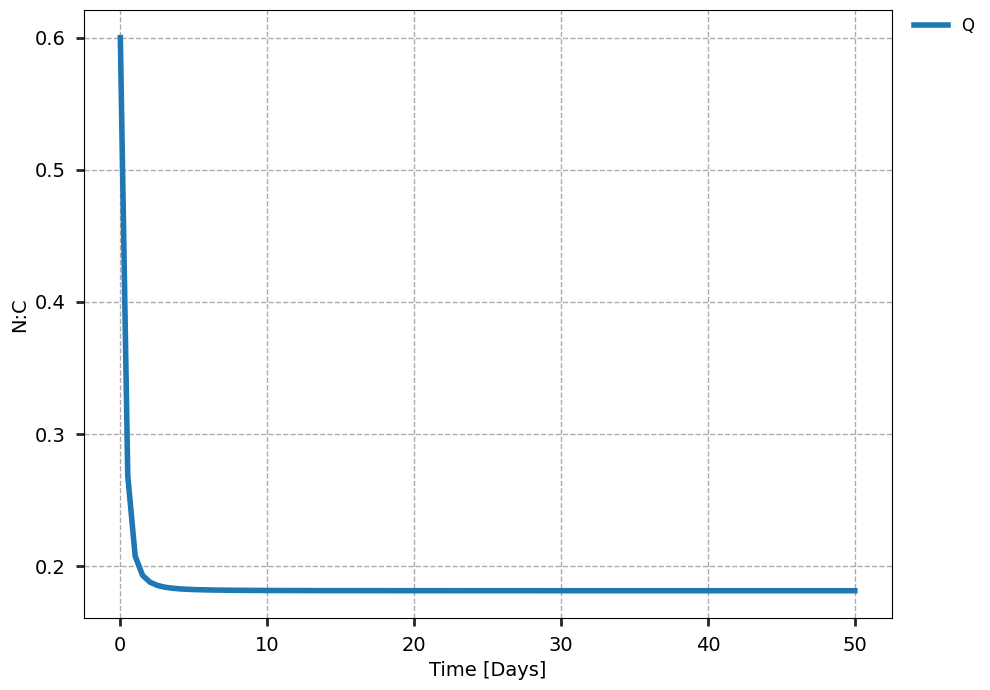

In [152]:
s=Simulator(G)
s.initialise ({"C":5,"N":3,"Chl":1})

s.simulate(50) # Simulates to a point where Q is constant
s.plot_selection("Q", xlabel = "Time [Days]", ylabel = "N:C") # Look at Q if it is constant

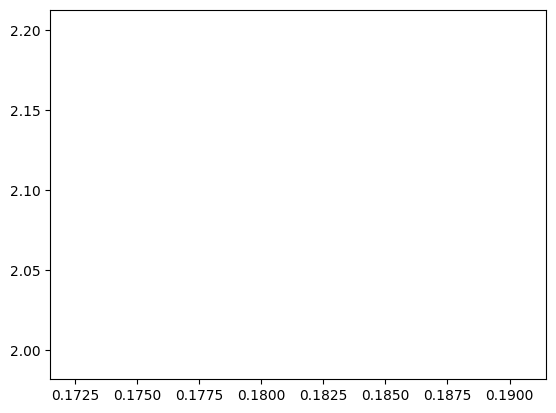

In [153]:
# Initialize lists
growth_rate_list = []
Q_list = []

# Get the last values
growth_rate = s.get_full_results_dict()["growth_rate"][-1]
Q = s.get_full_results_dict()["Q"][-1]

# Append to the lists
growth_rate_list.append(growth_rate)
Q_list.append(Q)


# Plot out values
fig, ax = plt.subplots()
ax.plot(Q, growth_rate)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

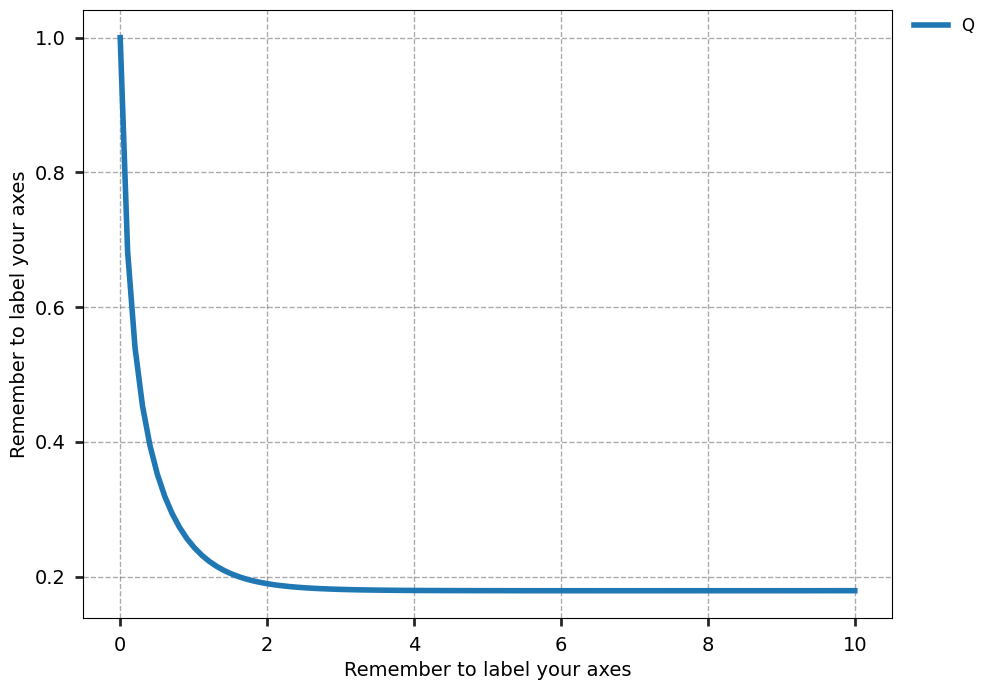

In [163]:
import numpy as np

for DIN in np.arange(0.1, 100, 1):
    s.initialise({"C":5,"N":5,"Chl":5})

    s.update_parameters({
        "DIN": DIN, "I": 189})
s.simulate(10) 
s.plot_selection("Q")

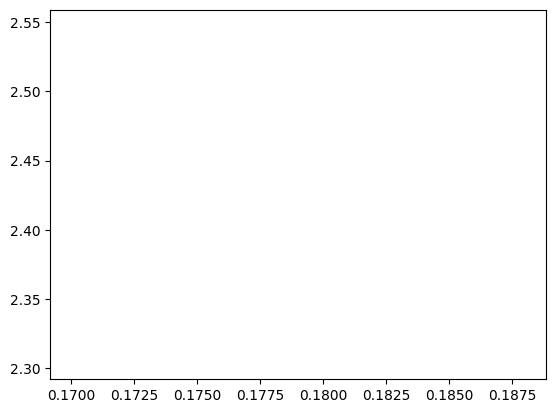

In [164]:
# Initialize lists
growth_rate_list = []
Q_list = []

# Get the last values
growth_rate = s.get_full_results_dict()["growth_rate"][-1]
Q = s.get_full_results_dict()["Q"][-1]

# Append to the lists
growth_rate_list.append(growth_rate)
Q_list.append(Q)


# Plot out values
fig, ax = plt.subplots()
ax.plot(Q, growth_rate)
